In [57]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import yfinance as yf
from sklearn.decomposition import PCA
import seaborn as sns
import itertools

In [111]:
class DataProcessor:
    def __init__(self):
        return
    
    def generate_train_test(self, df, seqLen, covid=True, split=0.8, trainLen=None, norm=False, pca=None):
        if not covid:
            df = df.loc[df.index < "2020-03-01"] 
        if trainLen is None:
            trainLen = int(len(df) * split)
        train = df.iloc[:trainLen]
        test = df.iloc[trainLen:]
        if pca is not None:
            pcaDfTrain = train.loc[:,pca].values
            pcaDfTest = test.loc[:,pca].values
            train.drop(pca, axis=1, inplace=True)
            test.drop(pca, axis=1, inplace=True)
            pcaObj = PCA(0.95)
            pcaObj.fit(pcaDfTrain)
            train = train.join(pd.DataFrame(pcaObj.transform(pcaDfTrain), index=train.index))
            test = test.join(pd.DataFrame(pcaObj.transform(pcaDfTest), index=test.index))
            plt.plot(range(1,pcaObj.n_components_+1), pcaObj.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
            plt.xlabel("Principal Component")
            plt.ylabel("Variance Explained")
            plt.show()
        print(train)
        if norm:
            l = train.min()
            h = train.max()
            self.l = l.iloc[0]
            self.h = h.iloc[0]
            train = (train - l)/(h-l)
            test = (test - l)/(h-l)
        targetTrain = train.iloc[:,0]
        targetTest = test.iloc[:,0]
        facTrain = train.iloc[:,1:]
        facTest = test.iloc[:,1:]
        
        xTrainL, yTrainL, xTestL, yTestL = [], [], [], []
        for i in range(len(train) - seqLen):
            xTrainL.append(np.hstack([targetTrain.iloc[i:(i+seqLen)].values.flatten("F"), facTrain.iloc[i:(i+seqLen)].values.flatten("F")]))
            yTrainL.append(targetTrain.iloc[(i+seqLen)].flatten())
        for i in range(len(test) - seqLen):
            xTestL.append(np.hstack([targetTest.iloc[i:(i+seqLen)].values.flatten("F"), facTest.iloc[i:(i+seqLen)].values.flatten("F")]))
            yTestL.append(targetTest.iloc[(i+seqLen)].flatten())
        self.trainLen = trainLen
        self.testStartDate = df.index[trainLen]
        return [np.array(xTrainL), np.array(yTrainL), np.array(xTestL), np.array(yTestL)]

In [ ]:
def generate_dataset(price, seq_len):
    X_list, y_list = [], []
    for i in range(len(price)-seq_len):
        X = np.array(price[i:i+seq_len])
        y = np.array([price[i+seq_len]])
        X_list.append(X)
        y_list.append(y)
    return np.array(X_list), np.array(y_list)def generate_dataset(price, seq_len):
    X_list, y_list = [], []
    for i in range(len(price)-seq_len):
        X = np.array(price[i:i+seq_len])
        y = np.array([price[i+seq_len]])
        X_list.append(X)
        y_list.append(y)
    return np.array(X_list), np.array(y_list)

In [119]:
def RMSE(y_true, y_label):
    return np.sqrt(np.mean((y_true - y_label)**2))

In [209]:
tf.random.set_seed(4012)

In [6]:
start = "2012-03-01"
end = "2022-03-01"
oilPrice = yf.download("CL=F", start=start, end=end).loc[:,["Close"]]
LAG = 5

[*********************100%***********************]  1 of 1 completed


In [7]:
opecPrice = pd.read_csv("./dataset/OPEC-ORB.csv", index_col=0, parse_dates=True)

In [9]:
facDict = {"Close": ["DX-Y.NYB"], "Volume": ["CL=F"]}
factors = list(set([i for arr in facDict.values() for i in arr]))
mulIdx = pd.MultiIndex.from_tuples([(key, val) for key in facDict.keys() for val in facDict.get(key)])
if len(factors) == 1:
    mulIdx = list(facDict.keys())
facDf = yf.download(factors, start=start, end=end).loc[:, mulIdx]
if facDf.columns.nlevels > 1:
    facDf.columns = [" ".join(pair[::-1]) for pair in facDf.columns]

[*********************100%***********************]  2 of 2 completed


In [10]:
tmpRatesDf = pd.read_csv("./dataset/rates.csv", index_col=0, parse_dates=True)
ratesDf = pd.DataFrame(index=oilPrice.index).join(tmpRatesDf).ffill()
ratesPeriod = [1/12, 1/4, 1/2, 1, 2, 3, 5, 7, 10]
contRatesDf = ratesDf.copy()
for i in range(len(ratesDf.columns)):
    if ratesPeriod[i] < 1:
        contRatesDf.iloc[:,i] = np.log(ratesDf.iloc[:,i]*ratesPeriod[i] + 1)/ratesPeriod[i]
    else:
        contRatesDf.iloc[:,i] = np.log((ratesDf.iloc[:,i] + 1) ** ratesPeriod[i])/ratesPeriod[i]
fwdRatesDf = contRatesDf.copy()
for i in range(1,len(ratesPeriod)):
    fwdRatesDf.iloc[:,i] = (contRatesDf.iloc[:,i]*ratesPeriod[i] - contRatesDf.iloc[:,(i-1)]*ratesPeriod[i-1]) / (ratesPeriod[i] - ratesPeriod[i-1])

# Different datasets

In [11]:
oilPrice
oils = oilPrice.join(opecPrice).ffill()
oilRates = oilPrice.join(fwdRatesDf)
oilVolCrncy = oilPrice.join(facDf).ffill()
oilVol = oilVolCrncy.drop(oilVolCrncy.columns[1],axis=1)
oilCrncy = oilVolCrncy.drop(oilVolCrncy.columns[-1],axis=1).ffill()
oilRatesCrncy = oilCrncy.join(fwdRatesDf).ffill()

# Multilayer Perceptron

In [2]:
def graphTrainTestLoss(model, title=None):
    plt.plot(range(1,len(model.modelHistory.history["loss"])+1), model.modelHistory.history["loss"], label="Train loss")
    plt.plot(range(1,len(model.modelHistory.history["val_loss"])+1), model.modelHistory.history["val_loss"], label="Test loss")
    plt.ylabel("MSE")
    plt.xlabel("epoch")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [226]:
class MLP:
    def __init__(self, xyTrainTest, batchNorm=None, dropout=None, dropoutProb=0.2, layerN=3, actFunc="relu", nn=64, alpha=0, lr=0.01):
        actFuncDict = {"relu": tf.keras.layers.ReLU(negative_slope=alpha), "tanh": tf.keras.layers.Activation('tanh')}
        assert isinstance(xyTrainTest, (list, tuple)) and (len(xyTrainTest) == 4)
        assert isinstance(actFunc, str) and actFunc.lower() in actFuncDict.keys()
        assert (batchNorm is None) or isinstance(batchNorm, (int, list, bool))
        assert (dropout is None) or isinstance(dropout, (int, list, bool))
        assert layerN > 0
        self.xTrain, self.yTrain, self.xTest, self.yTest = xyTrainTest
        self.trainLen = len(self.xTrain)
        self.layerN = layerN
        self.batchNorm = batchNorm
        self.dropout = dropout
        self.dropoutProb = dropoutProb
        self.actFunc = actFuncDict.get(actFunc.lower())
        self.nn = nn
        self.lr = lr
        self.unNorm = False
        self.donePred = False
        return
    
    def buildModel(self):
        layerN = self.layerN
        batchNorm = self.batchNorm
        dropout = self.dropout
        model = tf.keras.models.Sequential()
        for i in range(1,(layerN+1)):
            model.add(tf.keras.layers.Dense(self.nn, activation=self.actFunc))
            if batchNorm and (isinstance(batchNorm, bool) or (i == batchNorm) or (isinstance(batchNorm, list) and i in batchNorm)):
                model.add(tf.keras.layers.BatchNormalization())
            if dropout and (isinstance(dropout, bool) or (i == dropout) or (isinstance(dropout, list) and i in dropout)):
                model.add(tf.keras.layers.Dropout(self.dropoutProb))
        model.add(tf.keras.layers.Dense(1, activation=self.actFunc))
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        model.compile(optimizer=optimizer, loss="mse")
        return model

    def train(self, bs=32, ntry=15, epochs=100):
        validLen = int(self.trainLen * 0.2)
        model = self.buildModel()
        self.modelHistory = model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=epochs, shuffle=True, validation_data=(self.xTest, self.yTest), verbose=0)
        self.bestModel = model
        bestValidLoss = model.evaluate(self.xTrain[-validLen:], self.yTrain[-validLen:])
        bestTrainLoss = model.evaluate(self.xTrain, self.yTrain)
        for i in range(ntry):
            model = self.buildModel()
            history = model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=epochs, shuffle=True, validation_data=[self.xTest, self.yTest], verbose=0)
            if model.evaluate(self.xTrain, self.yTrain) < bestValidLoss:
                self.bestModel = model
                self.modelHistory = history
                bestValidLoss = model.evaluate(self.xTrain[-validLen:], self.yTrain[-validLen:])
                bestTrainLoss = model.evaluate(self.xTrain, self.yTrain)
        return [bestTrainLoss, bestValidLoss]

    def predict(self):
        if not self.donePred:
            self.yPred = self.bestModel.predict(self.xTest)
            self.yPredTrain = self.bestModel.predict(self.xTrain)
            self.donePred = True
        return
    
    def RMSE(self, train=False, l=None, h=None):
        if not self.donePred:
            self.predict()
            self.donePred = True
        if (not self.unNorm) and (l is not None) and (h is not None):
            self.yTrain = self.yTrain * (h-l) + l
            self.yPredTrain = self.yPredTrain * (h-l) + l
            self.yTest = self.yTest * (h-l) + l
            self.yPred = self.yPred * (h-l) + l
            self.unNorm = True
        if train:
            true = self.yTrain
            pred = self.yPredTrain
        else:
            true = self.yTest
            pred = self.yPred
        rmse = np.sqrt(np.mean(np.square(true-pred)))
        if not train:
            self.rmse = rmse
        return rmse
    
    def genGraph(self, l=None, h=None, title=None):
        testLen = len(self.yTest)
        if not self.donePred:
            self.predict()
            self.donePred = True
        yTest = self.yTest
        yPred = self.yPred
        if (not self.unNorm) and (l is not None) and (h is not None):
            yTest = yTest * (h-l) + l
            yPred = yPred * (h-l) + l
            self.yTest = yTest
            self.yPred = yPred
            self.yTrain = self.yTrain * (h-l) + l
            self.yPredTrain = self.yPredTrain * (h-l) + l
            self.unNorm = True
        plt.figure(figsize=(15, 10))
        plt.rcParams["font.size"] = "20"
        plt.plot(range(testLen), yTest, label="true")
        plt.plot(range(testLen), yPred, label="predict")
        if title is not None:
            plt.title(title)
        plt.ylabel("price", fontsize=15)
        plt.xlabel("trading days", fontsize=15)
        plt.legend(loc="lower right", fontsize=15)
        plt.show()
        return

# Testing with alternative data embedded

                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2018-07-18   68.760002
2018-07-19   69.459999
2018-07-20   70.459999
2018-07-23   67.889999
2018-07-24   68.519997

[1609 rows x 1 columns]
                 Close   Value
Date                          
2012-02-29  107.070000  120.79
2012-03-01  108.839996  122.12
2012-03-02  106.699997  123.12
2012-03-05  106.720001  122.39
2012-03-06  104.699997  122.02
...                ...     ...
2018-07-18   68.760002   69.98
2018-07-19   69.459999   70.91
2018-07-20   70.459999   71.57
2018-07-23   67.889999   71.85
2018-07-24   68.519997   72.01

[1609 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


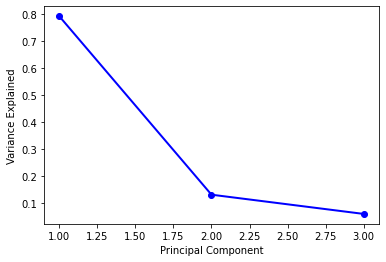

                 Close         0         1         2
Date                                                
2012-02-29  107.070000 -0.656685  0.317128  0.237028
2012-03-01  108.839996 -0.661008  0.284948  0.260232
2012-03-02  106.699997 -0.689269  0.326575  0.261684
2012-03-05  106.720001 -0.656589  0.314774  0.249326
2012-03-06  104.699997 -0.679028  0.366178  0.255307
...                ...       ...       ...       ...
2018-07-18   68.760002  2.265399 -0.038445  0.256005
2018-07-19   69.459999  2.255852 -0.021582  0.244477
2018-07-20   70.459999  2.246711 -0.043765  0.253177
2018-07-23   67.889999  2.267881 -0.075026  0.271275
2018-07-24   68.519997  2.287274 -0.077318  0.278722

[1609 rows x 4 columns]
                 Close  CL=F Volume
Date                               
2012-02-29  107.070000     353125.0
2012-03-01  108.839996     389838.0
2012-03-02  106.699997     299664.0
2012-03-05  106.720001     237450.0
2012-03-06  104.699997     332561.0
...                ...          ..

In [12]:
dataP = DataProcessor()
dataPset = dataP.generate_train_test(oilPrice, LAG, covid=False, norm=True)

dataPO = DataProcessor()
dataPOset = dataPO.generate_train_test(oils, LAG, covid=False, norm=True)

dataPR = DataProcessor()
dataPRset = dataPR.generate_train_test(oilRates, LAG, covid=False, norm=True, pca=fwdRatesDf.columns)

dataPV = DataProcessor()
dataPVset = dataPV.generate_train_test(oilVol, LAG, covid=False, norm=True)

dataPC = DataProcessor()
dataPCset = dataPC.generate_train_test(oilCrncy, LAG, covid=False, norm=True)

datasets = [[dataP, dataPset], [dataPO, dataPOset], [dataPR, dataPRset], [dataPV, dataPVset], [dataPC, dataPCset]]

In [13]:
lossDiffDS = []
modelDiffDS = []
for dataset in datasets:
    model = MLP(dataset[1])
    losses = model.train()
    losses.append(model.RMSE(l=dataset[0].l, h=dataset[0].h))
    lossDiffDS.append(losses)
    modelDiffDS.append(model)
pd.DataFrame(np.array(lossDiffDS), columns=["Train Loss", "Valid Loss", "Test Loss"])

50/50 [==============================] - 0s 873us/step - loss: 2.1042e-04


,Train Loss,Valid Loss,Test Loss
0,0.000954,0.000491,2.161473
1,0.000985,0.000534,2.328576
2,0.000295,0.000271,1.791296
3,0.000277,0.000207,1.566857
4,0.000358,0.000203,1.510274
5,0.000236,0.000189,1.371528


                 Close  DX-Y.NYB Close  CL=F Volume
Date                                               
2012-02-29  107.070000       78.730003     353125.0
2012-03-01  108.839996       78.779999     389838.0
2012-03-02  106.699997       79.400002     299664.0
2012-03-05  106.720001       79.320000     237450.0
2012-03-06  104.699997       79.860001     332561.0
...                ...             ...          ...
2018-07-18   68.760002       95.080002     187313.0
2018-07-19   69.459999       95.169998     103220.0
2018-07-20   70.459999       94.459999     500967.0
2018-07-23   67.889999       94.669998     555915.0
2018-07-24   68.519997       94.610001     524591.0

[1609 rows x 3 columns]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


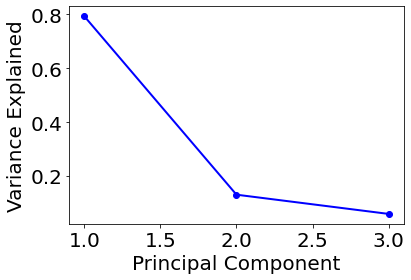

                 Close  DX-Y.NYB Close         0         1         2
Date                                                                
2012-02-29  107.070000       78.730003 -0.656685  0.317128  0.237028
2012-03-01  108.839996       78.779999 -0.661008  0.284948  0.260232
2012-03-02  106.699997       79.400002 -0.689269  0.326575  0.261684
2012-03-05  106.720001       79.320000 -0.656589  0.314774  0.249326
2012-03-06  104.699997       79.860001 -0.679028  0.366178  0.255307
...                ...             ...       ...       ...       ...
2018-07-18   68.760002       95.080002  2.265399 -0.038445  0.256005
2018-07-19   69.459999       95.169998  2.255852 -0.021582  0.244477
2018-07-20   70.459999       94.459999  2.246711 -0.043765  0.253177
2018-07-23   67.889999       94.669998  2.267881 -0.075026  0.271275
2018-07-24   68.519997       94.610001  2.287274 -0.077318  0.278722

[1609 rows x 5 columns]


In [39]:
dataPVC = DataProcessor()
dataPVCset = dataPVC.generate_train_test(oilVolCrncy, LAG, covid=False, norm=True)

dataPRC = DataProcessor()
dataPRCset = dataPRC.generate_train_test(oilRatesCrncy, LAG, covid=False, norm=True, pca=fwdRatesDf.columns)

datasetsCom = [[dataPVC, dataPVCset], [dataPRC, dataPRCset]]

In [40]:
lossDiffDSC = []
modelDiffDSC = []
for dataset in datasetsCom:
    model = MLP(dataset[1])
    losses = model.train()
    losses.append(model.RMSE(l=dataset[0].l, h=dataset[0].h))
    lossDiffDSC.append(losses)
    modelDiffDSC.append(model)
pd.DataFrame(np.array(lossDiffDSC), columns=["Train Loss", "Valid Loss", "Test Loss"])

51/51 [==============================] - 0s 910us/step - loss: 9.4790e-04


,Train Loss,Valid Loss,Test Loss
0,0.001332,0.000716,2.517006
1,0.000325,0.000215,1.655524


In [113]:
dataP = DataProcessor()
dataPset = dataP.generate_train_test(oilPrice, LAG, norm=True)

dataPV = DataProcessor()
dataPVset = dataPV.generate_train_test(oilVol, LAG, norm=True)

dataPC = DataProcessor()
dataPCset = dataPC.generate_train_test(oilCrncy, LAG, norm=True)

datasets = [[dataP, dataPset], [dataPV, dataPVset], [dataPC, dataPCset]]

                 Close
Date                  
2012-02-29  107.070000
2012-03-01  108.839996
2012-03-02  106.699997
2012-03-05  106.720001
2012-03-06  104.699997
...                ...
2020-02-25   49.900002
2020-02-26   48.730000
2020-02-27   47.090000
2020-02-28   44.759998
2020-03-02   46.750000

[2012 rows x 1 columns]
                 Close  CL=F Volume
Date                               
2012-02-29  107.070000     353125.0
2012-03-01  108.839996     389838.0
2012-03-02  106.699997     299664.0
2012-03-05  106.720001     237450.0
2012-03-06  104.699997     332561.0
...                ...          ...
2020-02-25   49.900002     764989.0
2020-02-26   48.730000     884482.0
2020-02-27   47.090000    1011915.0
2020-02-28   44.759998    1101659.0
2020-03-02   46.750000     949471.0

[2012 rows x 2 columns]
                 Close  DX-Y.NYB Close
Date                                  
2012-02-29  107.070000       78.730003
2012-03-01  108.839996       78.779999
2012-03-02  106.699997     

In [45]:
lossDiffD1 = []
modelDiffD1 = []
for dataset in datasets:
    model = MLP(dataset[1])
    losses = model.train()
    losses.append(model.RMSE(l=dataset[0].l, h=dataset[0].h))
    lossDiffD1.append(losses)
    modelDiffD1.append(model)
pd.DataFrame(np.array(lossDiffD1), columns=["Train Loss", "Valid Loss", "Test Loss"])

63/63 [==============================] - 0s 934us/step - loss: 3.5173e-04


,Train Loss,Valid Loss,Test Loss
0,0.000252,0.000214,4.246904
1,0.000219,0.000211,3.690416
2,0.000320,0.000221,3.719703


# Hyperparameters tuning

32, 2
63/63 [==============================] - 0s 791us/step - loss: 2.2421e-04
32, 3
63/63 [==============================] - 0s 746us/step - loss: 0.3108
32, 4
63/63 [==============================] - 0s 750us/step - loss: 2.9010e-04
32, 5
63/63 [==============================] - 0s 774us/step - loss: 2.7701e-04
64, 2
63/63 [==============================] - 0s 708us/step - loss: 2.5284e-04
64, 3
63/63 [==============================] - 0s 714us/step - loss: 2.9841e-04
64, 4
63/63 [==============================] - 0s 728us/step - loss: 3.1031e-04
64, 5
63/63 [==============================] - 0s 748us/step - loss: 2.3967e-04
128, 2
63/63 [==============================] - 0s 694us/step - loss: 2.4342e-04
128, 3
63/63 [==============================] - 0s 725us/step - loss: 0.3108
128, 4
63/63 [==============================] - 0s 807us/step - loss: 3.0608e-04
128, 5
63/63 [==============================] - 0s 789us/step - loss: 2.6509e-04
256, 2
63/63 [==============================

63/63 [==============================] - 0s 2ms/step - loss: 0.3108
256, 5
63/63 [==============================] - 0s 1ms/step - loss: 0.3108


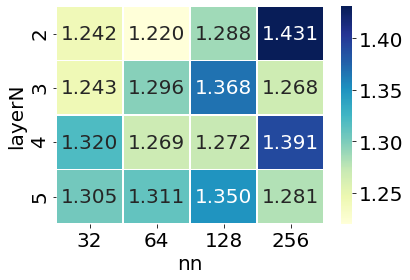

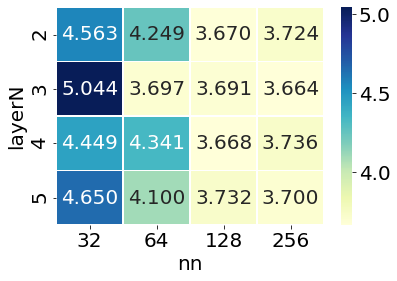

In [78]:
res = {"layerN": [], "nn": [], "train_rmse": [], "test_rmse": []}
for nn in [32,64,128,256]:
    for layerN in [2,3,4,5]:
        print(f"{nn}, {layerN}")
        m = MLP(dataPset, nn=nn, layerN=layerN)
        losses = m.train()
        res["layerN"].append(layerN)
        res["nn"].append(nn)
        res["train_rmse"].append(m.RMSE(train=True, l=dataP.l, h=dataP.h))
        res["test_rmse"].append(m.RMSE())
res = pd.DataFrame.from_dict(res)
sns.heatmap(res.pivot("layerN", "nn", "train_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()
sns.heatmap(res.pivot("layerN", "nn", "test_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()

In [86]:
class compare:
    def __init__(self, layerN=3, lr=[0.1,0.05,0.01,0.005], actFunc="relu", nueN=[32,64,128]):
        actFuncDict = {"relu": tf.nn.relu, "lrelu": tf.keras.layers.LeakyReLU, "tanh": tf.keras.activations.tanh}
        self.layerN = layerN
        self.lr = lr
        self.actFunc = actFuncDict[actFunc]
        self.nueN = nueN
        self.res = {'lr': [], 'nn': [], 'train_rmse': [],'test_rmse': []}
        
    def grid(self, xyTrainTest, l, h):
        tf.random.set_seed(4012)
        for (lr,nn) in itertools.product(self.lr, self.nueN):
            mod = MLP(xyTrainTest, lr=lr, nn=nn, batchNorm=True)
            tmp = mod.train()
            self.res['lr'].append(lr)
            self.res['nn'].append(nn)
            self.res['train_rmse'].append(mod.RMSE(train=True, l=l, h=h))
            self.res['test_rmse'].append(mod.RMSE())
        self.res = pd.DataFrame.from_dict(self.res)
        sns.heatmap(self.res.pivot("lr", "nn", "train_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
        plt.show()
        sns.heatmap(self.res.pivot("lr", "nn", "test_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
        plt.show()

63/63 [==============================] - 0s 977us/step - loss: 0.0031


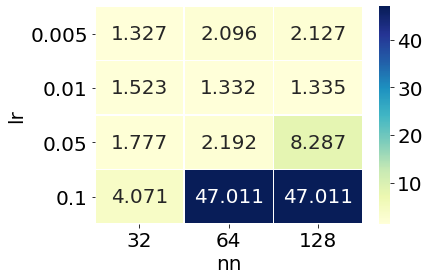

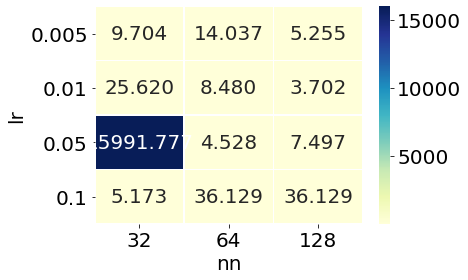

In [87]:
good = compare()
good.grid(dataPset, dataP.l, dataP.h)

[2, 64], True
63/63 [==============================] - 0s 928us/step - loss: 0.0013
[2, 64], False
63/63 [==============================] - 0s 790us/step - loss: 2.5284e-04
[2, 128], True
63/63 [==============================] - 0s 918us/step - loss: 5.5312e-04
[2, 128], False
63/63 [==============================] - 0s 719us/step - loss: 2.4342e-04
[3, 64], True
63/63 [==============================] - 0s 855us/step - loss: 0.0015
[3, 64], False
63/63 [==============================] - 0s 867us/step - loss: 2.9841e-04
[3, 128], True
63/63 [==============================] - 0s 873us/step - loss: 0.0015
[3, 128], False
63/63 [==============================] - 0s 845us/step - loss: 0.3108
[4, 64], True
63/63 [==============================] - 0s 916us/step - loss: 0.0014
[4, 64], False
63/63 [==============================] - 0s 770us/step - loss: 3.1031e-04
[4, 128], True
63/63 [==============================] - 0s 1ms/step - loss: 5.1286e-04
[4, 128], False
63/63 [=====================

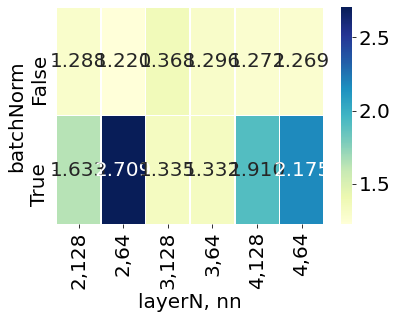

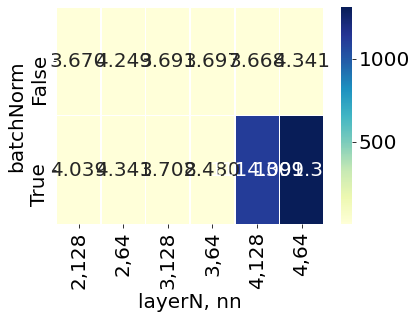

In [97]:
res = {"batchNorm": [], "layerN, nn": [], "train_rmse": [], "test_rmse": []}
for ln in [[2,64],[2,128],[3,64],[3,128],[4,64],[4,128]]:
    for batchNorm in [True, False]:
        print(f"{ln}, {batchNorm}")
        m = MLP(dataPset, layerN=ln[0], nn=ln[1], batchNorm=batchNorm)
        losses = m.train()
        res["batchNorm"].append(batchNorm)
        res["layerN, nn"].append(str(ln[0])+","+str(ln[1]))
        res["train_rmse"].append(m.RMSE(train=True, l=dataP.l, h=dataP.h))
        res["test_rmse"].append(m.RMSE())
res = pd.DataFrame.from_dict(res)
plt.figure(figsize=(10,4))
sns.heatmap(res.pivot("batchNorm", "layerN, nn", "train_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()
plt.figure(figsize=(10,4))
sns.heatmap(res.pivot("batchNorm", "layerN, nn", "test_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()

[2, 64, False], 0
63/63 [==============================] - 0s 806us/step - loss: 2.2787e-04
[2, 64, False], 0.1
63/63 [==============================] - 0s 893us/step - loss: 0.0013
[2, 128, False], 0
63/63 [==============================] - 0s 713us/step - loss: 2.4344e-04
[2, 128, False], 0.1
63/63 [==============================] - 0s 849us/step - loss: 7.0166e-04
[3, 64, True], 0
63/63 [==============================] - 0s 881us/step - loss: 2.7208e-04


63/63 [==============================] - 0s 1ms/step - loss: 3.2660e-04
[3, 64, True], 0.1
63/63 [==============================] - 0s 1ms/step - loss: 0.0012
[3, 64, False], 0
63/63 [==============================] - 0s 742us/step - loss: 0.3108
[3, 64, False], 0.1
63/63 [==============================] - 0s 726us/step - loss: 0.0013
[3, 128, True], 0
63/63 [==============================] - 0s 1ms/step - loss: 7.5634e-04
[3, 128, True], 0.1
63/63 [==============================] - 0s 1ms/step - loss: 0.0011
[4, 64, False], 0
63/63 [==============================] - 0s 888us/step - loss: 0.3108
[4, 64, False], 0.1
63/63 [==============================] - 0s 760us/step - loss: 8.9569e-04
[4, 128, False], 0
63/63 [==============================] - 0s 847us/step - loss: 2.3804e-04
[4, 128, False], 0.1
63/63 [==============================] - 0s 2ms/step - loss: 8.1364e-04


63/63 [==============================] - 0s 1ms/step - loss: 0.0011


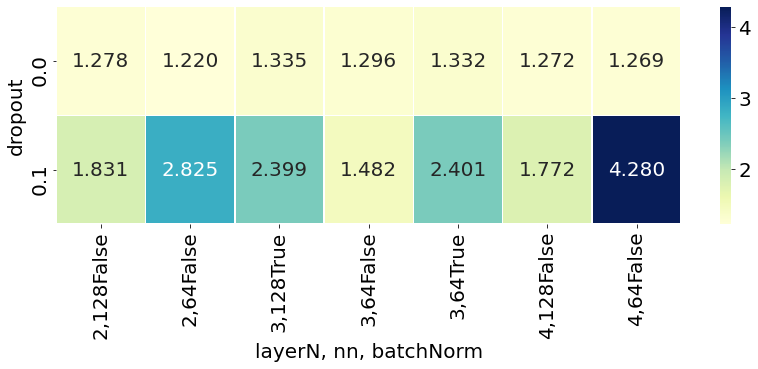

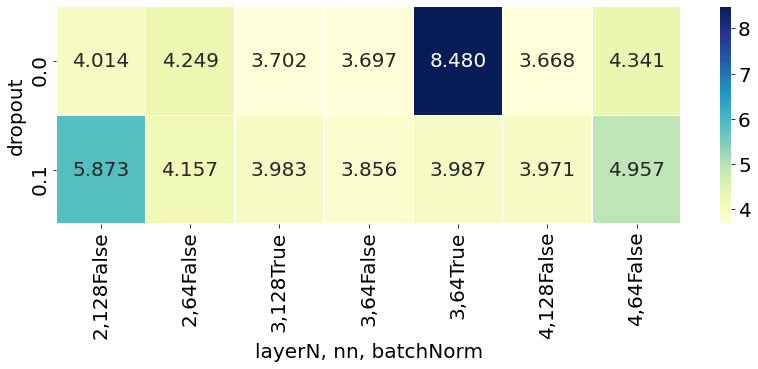

In [101]:
res = {"dropout": [], "layerN, nn, batchNorm": [], "train_rmse": [], "test_rmse": []}
for ln in [[2,64,False],[2,128,False],[3,64,True],[3,64,False],[3,128,True],[4,64,False],[4,128,False]]:
    for do in [[False,0],[True,0.1]]:
        print(f"{ln}, {do[1]}")
        m = MLP(dataPset, layerN=ln[0], nn=ln[1], dropout=do[0], dropoutProb=do[1], batchNorm=ln[2])
        losses = m.train(ntry=20)
        res["dropout"].append(do[1])
        res["layerN, nn, batchNorm"].append(str(ln[0])+","+str(ln[1])+","str(ln[2]))
        res["train_rmse"].append(m.RMSE(train=True, l=dataP.l, h=dataP.h))
        res["test_rmse"].append(m.RMSE())
res = pd.DataFrame.from_dict(res)
plt.figure(figsize=(14,4))
sns.heatmap(res.pivot("dropout", "layerN, nn, batchNorm", "train_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()
plt.figure(figsize=(14,4))
sns.heatmap(res.pivot("dropout", "layerN, nn, batchNorm", "test_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()

In [103]:
res = {"actFunc": [], "train_rmse": [], "test_rmse": []}
for af in [["relu",0],["relu",0.1],["relu",0.2],["relu",0.3],["relu",0.4],["relu",0.5],["tanh",0]]:
    print(af)
    m = MLP(dataPset, actFunc=af[0], alpha=af[1], layerN=4, nn=128)
    losses = m.train()
    res["actFunc"].append(af[0]+","+str(af[1]))
    res["train_rmse"].append(m.RMSE(train=True, l=dataP.l, h=dataP.h))
    res["test_rmse"].append(m.RMSE())
res = pd.DataFrame.from_dict(res)
print(res)

['relu', 0]
63/63 [==============================] - 0s 1ms/step - loss: 3.2894e-04
['relu', 0.1]
63/63 [==============================] - 0s 1ms/step - loss: 3.1123e-04
['relu', 0.2]
63/63 [==============================] - 0s 1ms/step - loss: 2.1301e-04
['relu', 0.3]
63/63 [==============================] - 0s 2ms/step - loss: 2.5092e-04
['relu', 0.4]
63/63 [==============================] - 0s 1ms/step - loss: 2.7361e-04
['relu', 0.5]
63/63 [==============================] - 0s 1ms/step - loss: 2.7941e-04
['tanh', 0]
63/63 [==============================] - 0s 962us/step - loss: 0.3255
    actFunc  train_rmse  test_rmse
0    relu,0    1.272091   3.668153
1  relu,0.1    1.296659   3.572752
2  relu,0.2    1.230631   3.329722
3  relu,0.3    1.225865   3.314016
4  relu,0.4    1.246377   3.254148
5  relu,0.5    1.234869   3.213339
6    tanh,0   48.108012  56.339131


# Proposed models with 2 datasets

2020-03-03 00:00:00
----------
63/63 [==============================] - 0s 733us/step - loss: 0.3110
----------
63/63 [==============================] - 0s 826us/step - loss: 2.4106e-04
----------
63/63 [==============================] - 0s 945us/step - loss: 4.3320e-04
----------
63/63 [==============================] - 0s 956us/step - loss: 0.0018
----------
63/63 [==============================] - 0s 869us/step - loss: 2.3166e-04
----------
63/63 [==============================] - 0s 960us/step - loss: 2.3093e-04


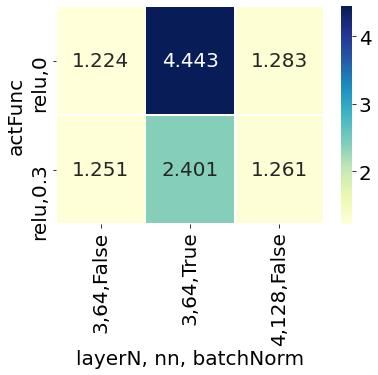

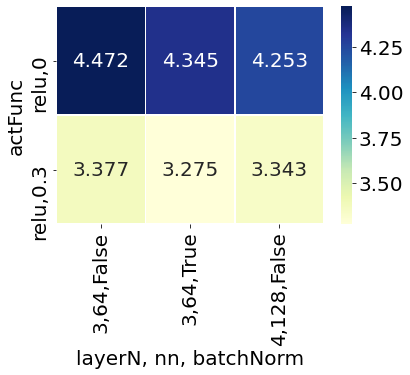

2020-03-03 00:00:00
----------
63/63 [==============================] - 0s 877us/step - loss: 2.4051e-04
----------
63/63 [==============================] - 0s 774us/step - loss: 2.1248e-04
----------
63/63 [==============================] - 0s 896us/step - loss: 5.8788e-04
----------
63/63 [==============================] - 0s 924us/step - loss: 0.0011
----------
63/63 [==============================] - 0s 740us/step - loss: 2.2187e-04
----------
63/63 [==============================] - 0s 889us/step - loss: 2.2064e-04


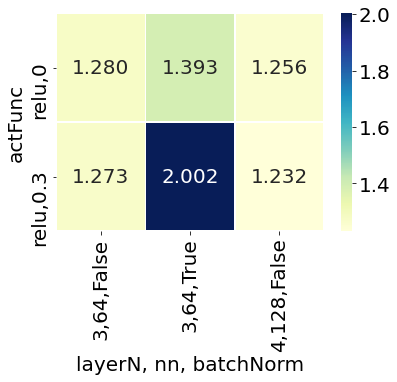

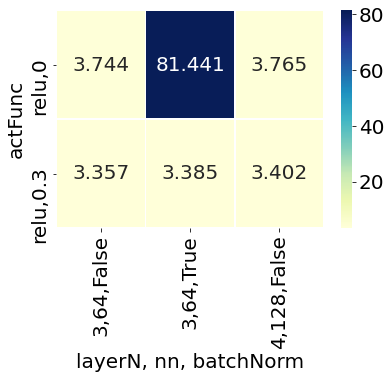

In [118]:
finalDS = [[dataP, dataPset], [dataPV, dataPVset]]
modelProp = []
for ds in finalDS:
    models = []
    print(ds[0].testStartDate)
    res = {"actFunc": [], "layerN, nn, batchNorm": [], "train_rmse": [], "test_rmse": []}
    for lnb in [[3,64,False], [3,64,True], [4,128,False]]:
        for af in [["relu",0],["relu",0.3]]:
            print("----------")
            tf.random.set_seed(4012)
            m = MLP(ds[1], actFunc=af[0], alpha=af[1], layerN=lnb[0], nn=lnb[1], batchNorm=lnb[2])
            losses = m.train(ntry=20)
            res["actFunc"].append(af[0]+","+str(af[1]))
            res["layerN, nn, batchNorm"].append(str(lnb[0])+","+str(lnb[1])+","+str(lnb[2]))
            res["train_rmse"].append(m.RMSE(train=True, l=ds[0].l, h=ds[0].h))
            res["test_rmse"].append(m.RMSE())
            models.append(m)
    modelProp.append(models)
    res = pd.DataFrame.from_dict(res)
    sns.heatmap(res.pivot("actFunc", "layerN, nn, batchNorm", "train_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
    plt.show()
    sns.heatmap(res.pivot("actFunc", "layerN, nn, batchNorm", "test_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
    plt.show()

# Generate graph for monitoring overfitting

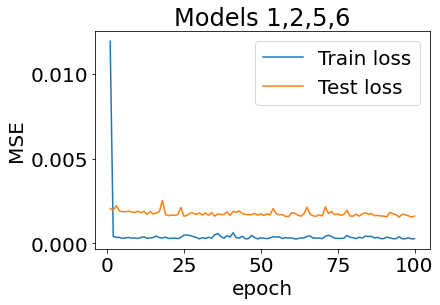

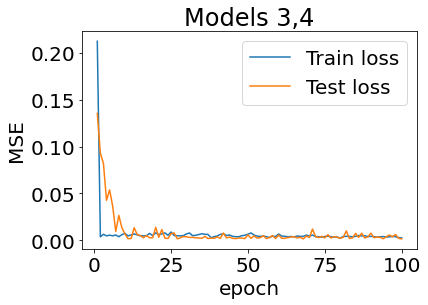

In [198]:
graphTrainTestLoss(modelProp[0][1], title="Models 1,2,5,6")
graphTrainTestLoss(modelProp[0][3], title="Models 3,4")

# 64 Neurons on 3 layers, batch normalization, leaky ReLU with alpha = 0.3

63/63 [==============================] - 0s 924us/step - loss: 9.1861e-04


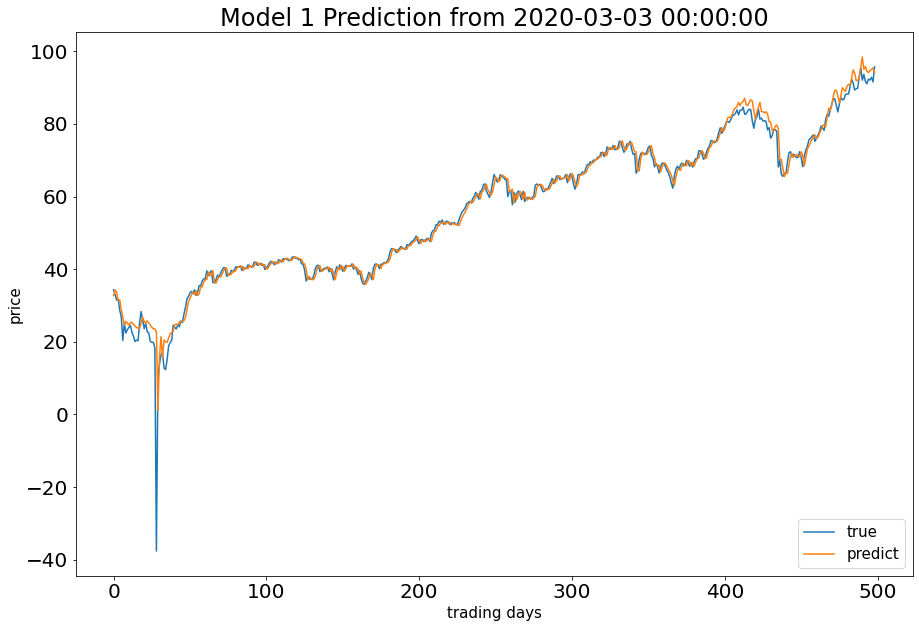

2.4009662081191765
3.2754299137039915
1.709883377214655


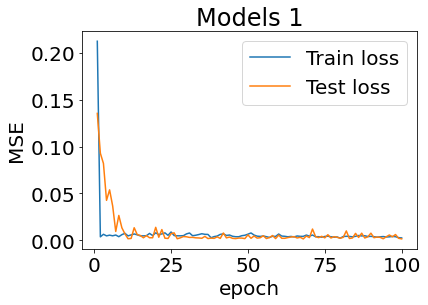

In [229]:
tf.random.set_seed(4012)
model1 = MLP(dataPset, batchNorm=True, layerN=3, nn=64, alpha=0.3)
model1.train(ntry=15)
model1.genGraph(l=dataP.l, h=dataP.h, title=f"Model 1 Prediction from {dataP.testStartDate}")
print(model1.RMSE(train=True))
print(model1.RMSE())
# RMSE excluding negarive oil price in the testing set
startD = np.argmin(model1.yTest) + 2
print(RMSE(model1.yTest[startD:], model1.yPred[startD:]))
graphTrainTestLoss(model1, title="Models 1")

# 128 Neurons on 3 layers, batch normalization, leaky ReLU with alpha = 0.3

63/63 [==============================] - 0s 1ms/step - loss: 0.0013


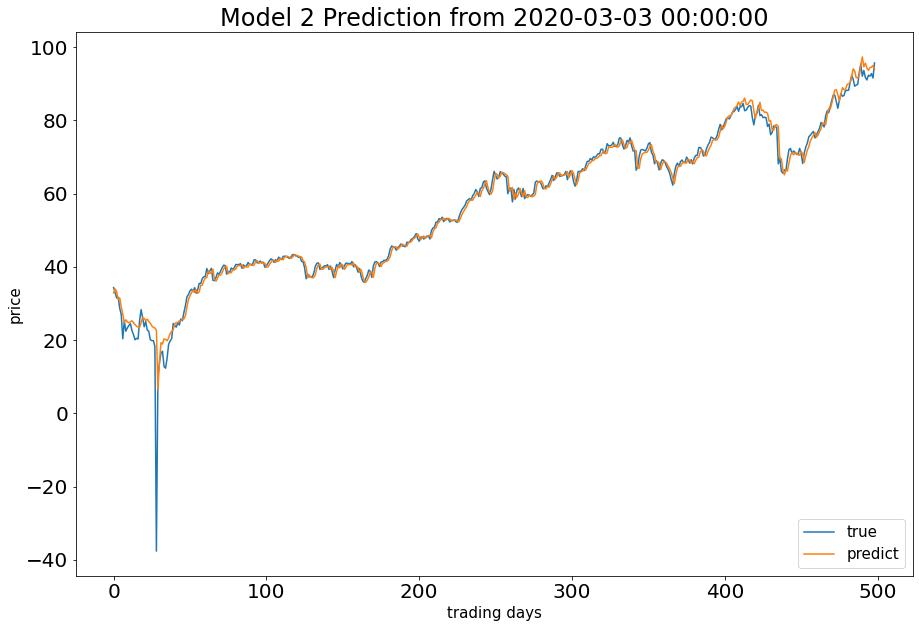

2.024508728114839
3.2011072053116094
1.607262006323531


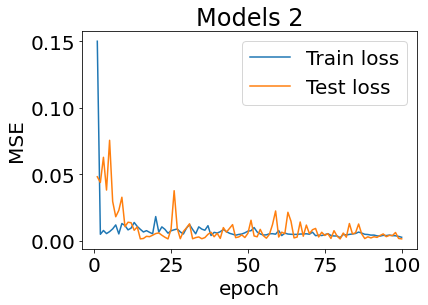

In [231]:
tf.random.set_seed(4012)
model2 = MLP(dataPset, batchNorm=True, layerN=3, nn=128, alpha=0.3)
model2.train(ntry=15)
model2.genGraph(l=dataP.l, h=dataP.h, title=f"Model 2 Prediction from {dataP.testStartDate}")
print(model2.RMSE(train=True))
print(model2.RMSE())
# RMSE excluding negarive oil price in the testing set
startD = np.argmin(model2.yTest) + 2
print(RMSE(model2.yTest[startD:], model2.yPred[startD:]))
graphTrainTestLoss(model2, title="Models 2")

In [238]:
print(np.min(model1.yPred))
print(np.min(model1.yPred))

-37.630001068115234

# Simple Linear Regression

In [ ]:
data = DataProcessor()
X_train, y_train, X_test, y_test = data.generate_train_test(oilPrice, LAG)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
test_len = len(y_test) 
plt.figure(figsize=(15,10)) 
plt.rcParams['font.size'] = "20"
plt.plot(range(test_len), y_test, label="true") 
plt.plot(range(test_len), reg.predict(X_test), label="predict") 
plt.title(f"""{stock} prediction from {data.testStartDate}""", fontsize= 35)
plt.ylabel("price", fontsize= 25) 
plt.xlabel("trading days", fontsize= 25) 
plt.legend(loc="lower right", fontsize= 25)

In [ ]:
RMSE(y_test, reg.predict(X_test))

# LSTM

In [ ]:
start = "2012-03-01"
end = "2022-03-01"
stock = "CL=F"
df = yf.download(tickers=stock, start=start, end=end, progress=False)
train_len = int((len(df)*0.8))
df_train = df["Close"].iloc[:train_len].values
df_test = df["Close"].iloc[train_len:].values

tf.random.set_seed(4012)
LAG = 5
nneuron = [32,64,128,256]
dropout = [True, False]

# Model Picking

In [ ]:
model_rmse = {'dropout': [], 'nn': [], 'train_rmse': [],'test_rmse': []}

for i in range(len(dropout)):
    for j in range(len(nneuron)):
        X_train, y_train = generate_dataset(df_train, seq_len = LAG)
        X_test, y_test = generate_dataset(df_test, seq_len = LAG)
    
        test_len = len(y_test)
        h = max(df_train)
        l = min(df_train)

        X_train = (X_train - l)/(h-l)
        y_train = (y_train - l)/(h-l)
        X_test = (X_test - l)/(h-l)
        y_test = (y_test - l)/(h-l)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        model = Sequential()
        model.add(LSTM(nneuron[j]))
        if (dropout[i]):
            model.add(Dropout(0.2))
        model.add(Dense(1))
        optimizer = Adam(learning_rate = 0.001)
        model.compile(optimizer=optimizer, loss='mse')
        model.fit(X_train, y_train, batch_size=32, epochs=100, shuffle=True)
        
        y_pred_train = np.squeeze(model.predict(X_train))*(h-l)+l
        train_RMSE = RMSE(y_pred_train, y_train[:,0]*(h-l)+l)
        y_pred = np.squeeze(model.predict(X_test))*(h-l)+l
        test_RMSE = RMSE(y_pred, y_test[:,0]*(h-l)+l)
        
        model_rmse['dropout'].append(dropout[i])
        model_rmse['nn'].append(nneuron[j])
        model_rmse['train_rmse'].append(train_RMSE)
        model_rmse['test_rmse'].append(test_RMSE)

In [ ]:
model_rmse = pd.DataFrame.from_dict(model_rmse)
sns.heatmap(model_rmse.pivot("dropout", "nn", "train_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()
sns.heatmap(model_rmse.pivot("dropout", "nn", "test_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show() 

In [ ]:
nlayer = [1, 2, 3]
nneuron = [32,64,128,256]
model2_rmse = {'n_layer': [], 'nn': [], 'train_rmse': [],'test_rmse': []}

for i in range(len(nlayer)):
    for j in range(len(nneuron)):
        X_train, y_train = generate_dataset(df_train, seq_len = LAG)
        X_test, y_test = generate_dataset(df_test, seq_len = LAG)
    
        test_len = len(y_test)
        h = max(df_train)
        l = min(df_train)

        X_train = (X_train - l)/(h-l)
        y_train = (y_train - l)/(h-l)
        X_test = (X_test - l)/(h-l)
        y_test = (y_test - l)/(h-l)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        model = Sequential()
        for k in range(nlayer[i]):
            if (k == nlayer[i]-1):
                model.add(LSTM(nneuron[j]))
            else:
                model.add(LSTM(nneuron[j], return_sequences = True))
        model.add(Dense(1))
        optimizer = Adam(learning_rate = 0.001)
        model.compile(optimizer=optimizer, loss='mse')
        model.fit(X_train, y_train, batch_size=32, epochs=100, shuffle=True)
        
        y_pred_train = np.squeeze(model.predict(X_train))*(h-l)+l
        train_RMSE = RMSE(y_pred_train, y_train[:,0]*(h-l)+l)
        y_pred = np.squeeze(model.predict(X_test))*(h-l)+l
        test_RMSE = RMSE(y_pred, y_test[:,0]*(h-l)+l)
        
        model2_rmse['n_layer'].append(nlayer[i])
        model2_rmse['nn'].append(nneuron[j])
        model2_rmse['train_rmse'].append(train_RMSE)
        model2_rmse['test_rmse'].append(test_RMSE)

In [ ]:
model2_rmse = pd.DataFrame.from_dict(model2_rmse)
sns.heatmap(model2_rmse.pivot("n_layer", "nn", "train_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show()
sns.heatmap(model2_rmse.pivot("n_layer", "nn", "test_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.show() 

# final LSTM models

In [ ]:
class LSTM_stock:
    def __init__(self, dropout=True, layerN=1, lr=0.001, actFunc="tanh", nueN=128):
        actFuncDict = {"relu": tf.nn.relu, "lrelu": tf.keras.layers.LeakyReLU, "tanh": tf.keras.activations.tanh}
        self.layerN = layerN
        self.dropout = dropout
        self.lr = lr
        self.actFunc = actFuncDict[actFunc]
        self.nueN = nueN
    
    def build_model(self):
        model = tf.keras.models.Sequential()
        for i in range(self.layerN):
            if (i == self.layerN-1):
                model.add(LSTM(self.nueN))
            else:
                model.add(LSTM(self.nueN, return_sequences = True))
            if self.dropout:
                model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(1, activation=self.actFunc))
        optimizer = tf.keras.optimizers.Adam(lr=self.lr) 
        model.compile(optimizer=optimizer, loss="mse")
        return(model)

    def train(self,X_train,y_train,bs=32,ntry=1):
        eva = int(len(X_train) * 0.2)
        model = self.build_model()
        model.fit(X_train,y_train,batch_size=bs,epochs=100,shuffle=True,verbose=0)
        self.best_model = model
        best_loss = model.evaluate(X_train[-eva :], y_train[-eva :]) 
        best_loss2 = model.evaluate(X_train, y_train) 
        for i in range(ntry): 
            model = self.build_model() 
            model.fit(X_train,y_train, batch_size=bs, epochs= 100, shuffle=True,verbose=0) 
            if model.evaluate(X_train, y_train) < best_loss: 
                self.best_model = model 
                best_loss = model.evaluate(X_train[-eva :], y_train[-eva :])
                best_loss2 = model.evaluate(X_train, y_train) 
        return [best_loss,best_loss2]
                       
    def predict(self, X_test): 
        return (self.best_model.predict(X_test))
    
    def RMSE(self, y_pred, y_true):
        return np.sqrt(np.mean((y_true - y_pred)**2))

In [ ]:
class compare:
    def __init__(self, lr=[0.1,0.05,0.01], actFunc="tanh", nueN=[32,64,128,256]):
        actFuncDict = {"relu": tf.nn.relu, "lrelu": tf.keras.layers.LeakyReLU, "tanh": tf.keras.activations.tanh}
        self.lr = lr
        self.actFunc = actFuncDict[actFunc]
        self.nueN = nueN
        self.res = {'lr': [], 'nn': [], 'train_rmse': [],'valid_rmse': []}
        
    def grid(self,X_train,y_train):
        tf.random.set_seed(4012)
        for (lr,nn) in itertools.product(self.lr, self.nueN):
            mod = LSTM_stock(lr=lr,nueN=nn)
            tmp = mod.train(X_train, y_train)
            self.res['lr'].append(lr)
            self.res['nn'].append(nn)
            self.res['train_rmse'].append(tmp[1])
            self.res['valid_rmse'].append(tmp[0])
        self.res = pd.DataFrame.from_dict(self.res)
        sns.heatmap(self.res.pivot("lr", "nn", "train_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
        plt.show()
        sns.heatmap(self.res.pivot("lr", "nn", "valid_rmse"), annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
        plt.show()    

In [ ]:
LAG = 5
X_train, y_train = generate_dataset(df_train, seq_len = LAG)
X_test, y_test = generate_dataset(df_test, seq_len = LAG)

test_len = len(y_test)
h = max(df_train)
l = min(df_train)

X_train = (X_train - l)/(h-l)
y_train = (y_train - l)/(h-l)
X_test = (X_test - l)/(h-l)
y_test = (y_test - l)/(h-l)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Number of neuron = 64, Dropout = False

In [ ]:
tf.random.set_seed(4012)
model = LSTM_stock(dropout=False, layerN=1, lr=0.001, actFunc="tanh", nueN=64) 
model.train(X_train, y_train) 
y_pred = np.squeeze(model.predict(X_test))*(h-l)+l

In [ ]:
y_pred_avg_LAG = np.mean(X_test, axis=1)*(h-l)+l
y_pred_train = np.squeeze(model.predict(X_train))*(h-l)+l
plt.figure(figsize=(15,10)) 
#setting font size to be 20 for all the text in the plot 
plt.rcParams['font.size'] = "20"
plt.plot(range(len(y_train)), y_train*(h-l)+l, label="true") 
plt.plot(range(len(y_train)), y_pred_train, label="predict")
plt.legend(loc="lower right", fontsize= 25) 
plt.show()

In [ ]:
plt.figure(figsize=(15,10)) 
#setting font size to be 20 for all the text in the plot 
plt.rcParams['font.size'] = "20"
plt.plot(range(test_len), y_test*(h-l)+l, label="true") 
plt.plot(range(test_len), y_pred, label="predict") 
plt.title(f"""Prediction from {df.index[train_len]} (Number of neuron = 64)""", fontsize= 25)
plt.ylabel("price", fontsize= 25) 
plt.xlabel("trading days", fontsize= 25) 
plt.legend(loc="lower right", fontsize= 25) 
plt.show()

In [ ]:
print(model.RMSE(y_pred_train,y_train[:,0]*(h-l)+l))
print(model.RMSE(y_pred,y_test[:,0]*(h-l)+l))
print(model.RMSE(y_pred_avg_LAG,y_test[:,0]*(h-l)+l))

In [ ]:
# RMSE excluding negarive oil price in the testing set
start_day = np.argmin(y_test[:,0]) + 2
print(model.RMSE(y_pred[start_day:],y_test[start_day:,0]*(h-l)+l))
print(model.RMSE(y_pred_avg_LAG[start_day:],y_test[start_day:,0]*(h-l)+l))

In [ ]:
min(y_pred)

# Number of neuron = 128, Dropout = False

In [ ]:
tf.random.set_seed(4012)
model2 = LSTM_stock(dropout=False, layerN=1, lr=0.001, actFunc="tanh", nueN=128) 
model2.train(X_train, y_train, ntry=1) 
y_pred2 = np.squeeze(model2.predict(X_test))*(h-l)+l

In [ ]:
y_pred2_avg_LAG = np.mean(X_test, axis=1)*(h-l)+l
y_pred2_train = np.squeeze(model2.predict(X_train))*(h-l)+l
plt.figure(figsize=(15,10)) 
#setting font size to be 20 for all the text in the plot 
plt.rcParams['font.size'] = "20"
plt.plot(range(len(y_train)), y_train*(h-l)+l, label="true") 
plt.plot(range(len(y_train)), y_pred2_train, label="predict")
plt.legend(loc="lower right", fontsize= 25) 
plt.show()y_pred2_avg_LAG = np.mean(X_test, axis=1)*(h-l)+l
y_pred2_train = np.squeeze(model2.predict(X_train))*(h-l)+l
plt.figure(figsize=(15,10)) 
#setting font size to be 20 for all the text in the plot 
plt.rcParams['font.size'] = "20"
plt.plot(range(len(y_train)), y_train*(h-l)+l, label="true") 
plt.plot(range(len(y_train)), y_pred2_train, label="predict")
plt.legend(loc="lower right", fontsize= 25) 
plt.show()

In [ ]:
plt.figure(figsize=(15,10)) 
#setting font size to be 20 for all the text in the plot 
plt.rcParams['font.size'] = "20"
plt.plot(range(test_len), y_test*(h-l)+l, label="true") 
plt.plot(range(test_len), y_pred2, label="predict") 
plt.title(f"""Prediction from {df.index[train_len]} (Number of neuron = 128)""", fontsize= 25)
plt.ylabel("price", fontsize= 25) 
plt.xlabel("trading days", fontsize= 25) 
plt.legend(loc="lower right", fontsize= 25) 
plt.show()

In [ ]:
print(model2.RMSE(y_pred2_train,y_train[:,0]*(h-l)+l))
print(model2.RMSE(y_pred2,y_test[:,0]*(h-l)+l))
print(model2.RMSE(y_pred2_avg_LAG,y_test[:,0]*(h-l)+l))

In [ ]:
print(model2.RMSE(y_pred2[start_day:],y_test[start_day:,0]*(h-l)+l))
print(model2.RMSE(y_pred2_avg_LAG[start_day:],y_test[start_day:,0]*(h-l)+l))

In [ ]:
min(y_pred2)

# Number of neuron = 256, Dropout = False

In [ ]:
y_pred3_avg_LAG = np.mean(X_test, axis=1)*(h-l)+l
y_pred3_train = np.squeeze(model3.predict(X_train))*(h-l)+l
plt.figure(figsize=(15,10)) 
#setting font size to be 20 for all the text in the plot 
plt.rcParams['font.size'] = "20"
plt.plot(range(len(y_train)), y_train*(h-l)+l, label="true") 
plt.plot(range(len(y_train)), y_pred3_train, label="predict")
plt.legend(loc="lower right", fontsize= 25) 
plt.show()

In [ ]:
plt.figure(figsize=(15,10)) 
#setting font size to be 20 for all the text in the plot 
plt.rcParams['font.size'] = "20"
plt.plot(range(test_len), y_test*(h-l)+l, label="true") 
plt.plot(range(test_len), y_pred3, label="predict") 
plt.title(f"""Prediction from {df.index[train_len]} (Number of neuron = 256)""", fontsize= 25)
plt.ylabel("price", fontsize= 25) 
plt.xlabel("trading days", fontsize= 25) 
plt.legend(loc="lower right", fontsize= 25) 
plt.show()

In [ ]:
print(model3.RMSE(y_pred3_train,y_train[:,0]*(h-l)+l))
print(model3.RMSE(y_pred3,y_test[:,0]*(h-l)+l))
print(model3.RMSE(y_pred3_avg_LAG,y_test[:,0]*(h-l)+l))

In [ ]:
print(model3.RMSE(y_pred3[start_day:],y_test[start_day:,0]*(h-l)+l))
print(model3.RMSE(y_pred3_avg_LAG[start_day:],y_test[start_day:,0]*(h-l)+l))

In [ ]:
min(y_pred3)